<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingSegmentationData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install defisheye supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done


In [ ]:
from defisheye import Defisheye
import supervision as sv
import numpy as np
import pandas as pd
import torch
import PIL
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import cv2
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CurlingDataset(Dataset):

  _train = None
  _test = None
  _validate = None

  def __init__(self, csv_loc, img_dir, set_type="train", transform=None, target_transform=None):
    self.data = pd.read_csv(csv_loc)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

    print(self.data)


    if type(CurlingDataset._train) == type(None):
      print("Performing a split")
      CurlingDataset._train, CurlingDataset._test, CurlingDataset._validate = self.__split()

    self.data = CurlingDataset._train if set_type == "train" else (CurlingDataset._test if set_type == "test" else CurlingDataset._validate)

  def __len__(self):
    return len(self.data)

  def __split(self):

    train, test = train_test_split(self.data, train_size=.70, stratify=self.data['empty'])
    test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])

    return train, test, validate

  def __getitem__(self, index):

    img_path = os.path.join(self.img_dir, self.data.iloc[index, 1])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = torch.tensor(int(self.data.iloc[index, 2]))

    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="train",
    transform=transform
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="test",
    transform=transform
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="validate",
    transform=transform
)

      filename         filepath  empty
0        0.jpg     images/0.jpg      0
1        1.jpg     images/1.jpg      1
2        2.jpg     images/2.jpg      1
3        3.jpg     images/3.jpg      1
4        4.jpg     images/4.jpg      1
...        ...              ...    ...
1865  1865.jpg  images/1865.jpg      0
1866  1866.jpg  images/1866.jpg      0
1867  1867.jpg  images/1867.jpg      1
1868  1868.jpg  images/1868.jpg      0
1869  1869.jpg  images/1869.jpg      1

[1870 rows x 3 columns]
Performing a split
      filename         filepath  empty
0        0.jpg     images/0.jpg      0
1        1.jpg     images/1.jpg      1
2        2.jpg     images/2.jpg      1
3        3.jpg     images/3.jpg      1
4        4.jpg     images/4.jpg      1
...        ...              ...    ...
1865  1865.jpg  images/1865.jpg      0
1866  1866.jpg  images/1866.jpg      0
1867  1867.jpg  images/1867.jpg      1
1868  1868.jpg  images/1868.jpg      0
1869  1869.jpg  images/1869.jpg      1

[1870 rows x 3 colu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint="sam_vit_h_4b8939.pth").to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

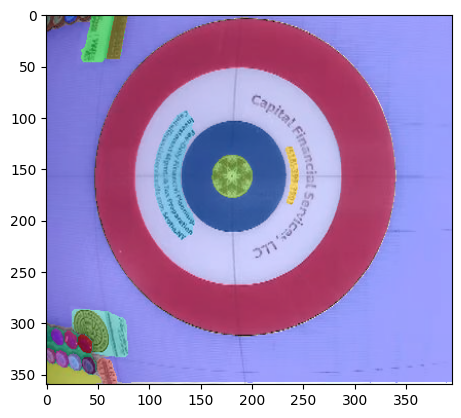

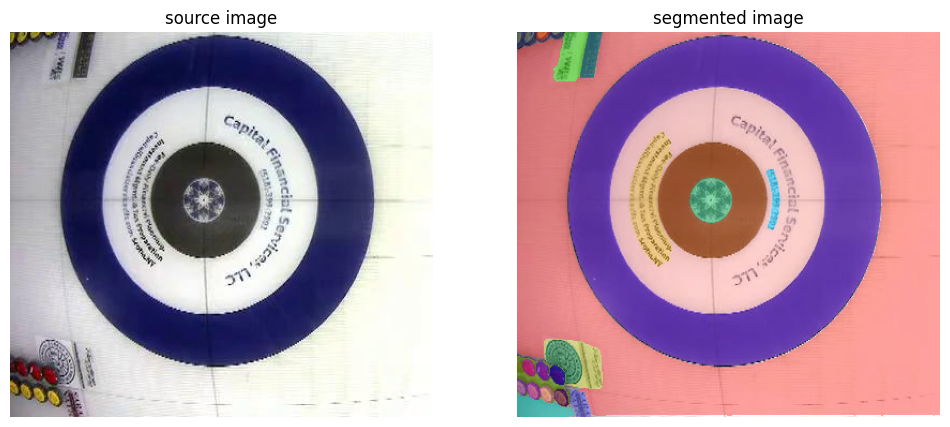

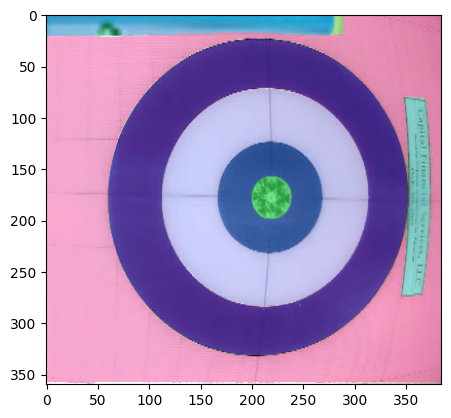

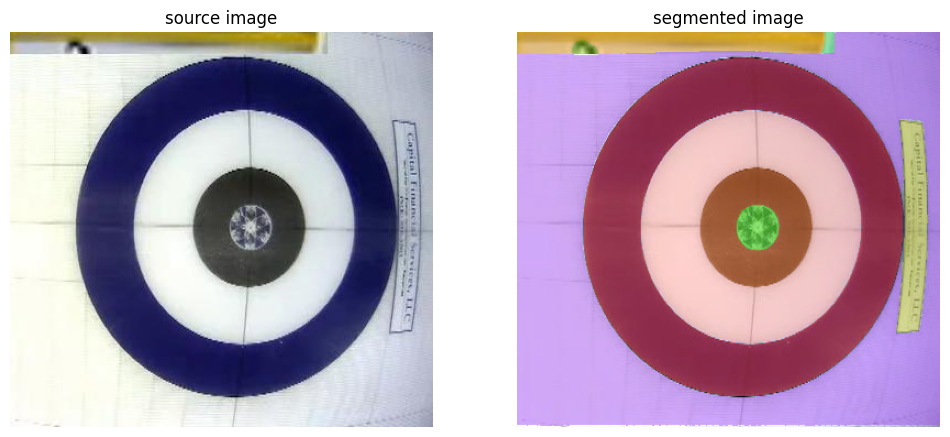

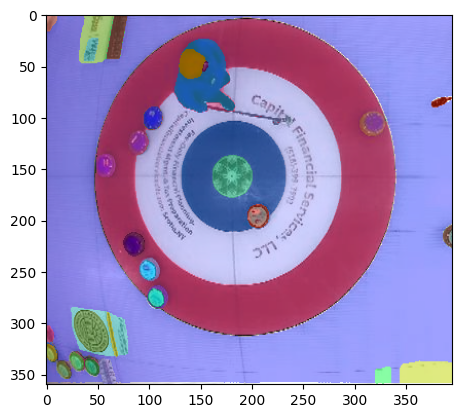

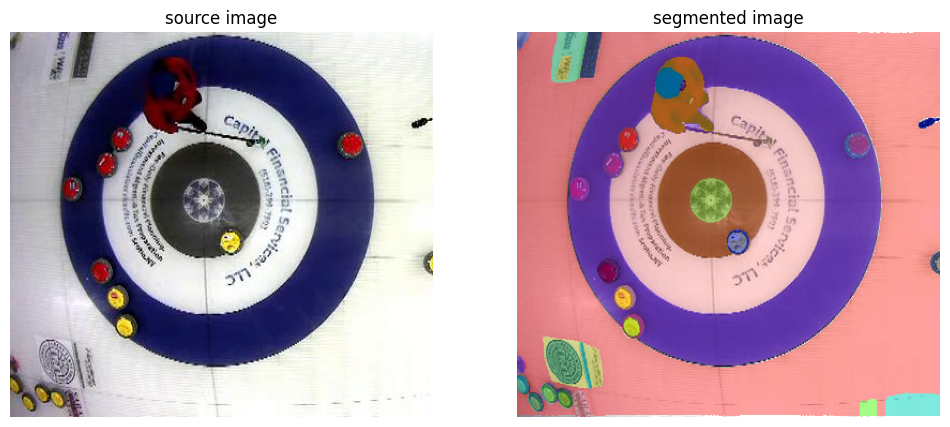

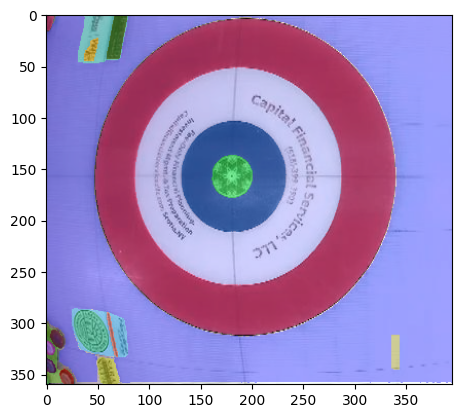

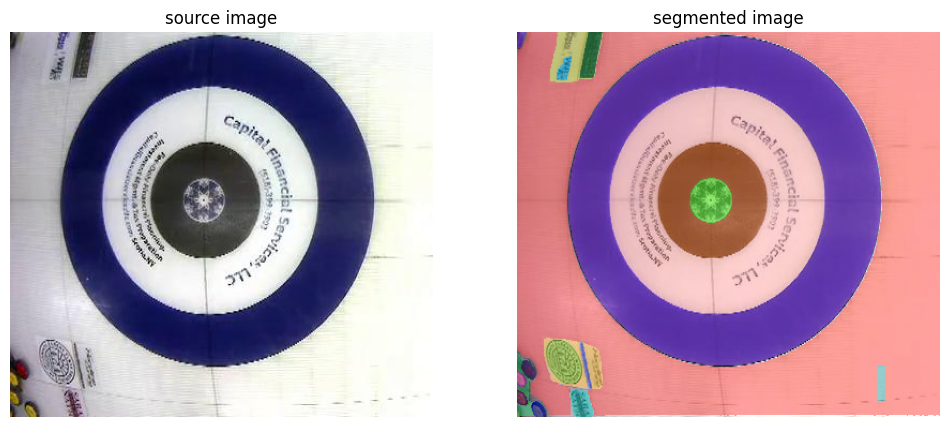

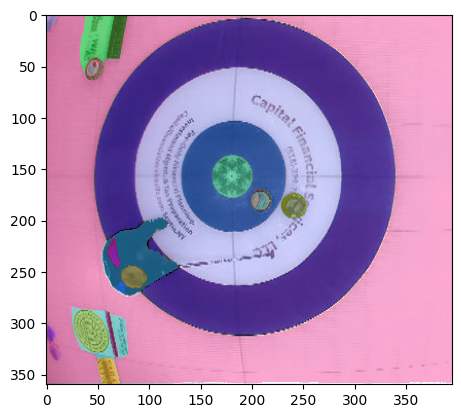

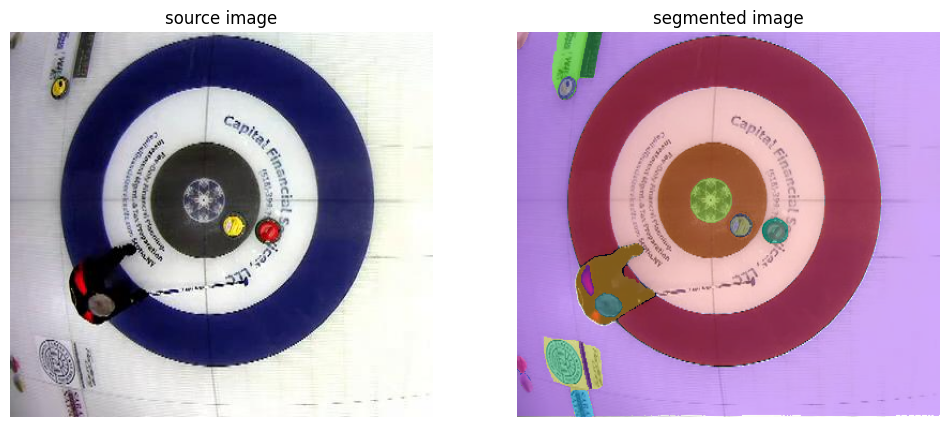

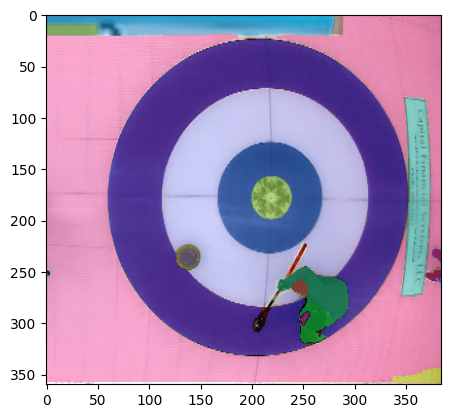

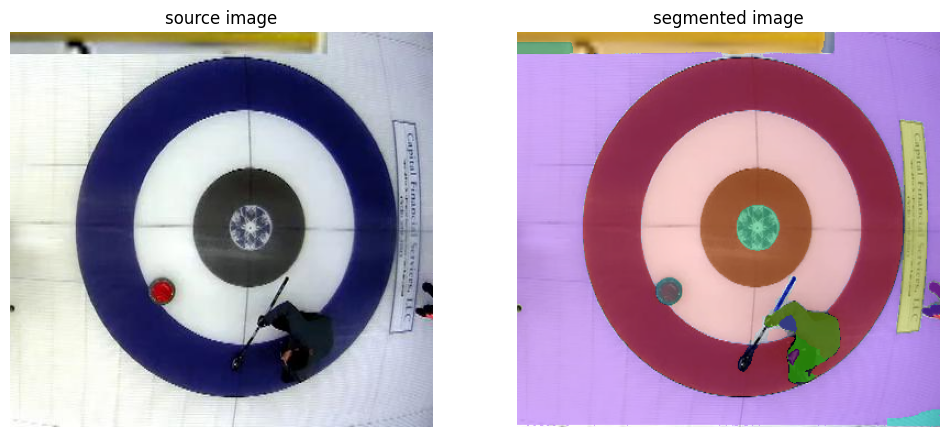

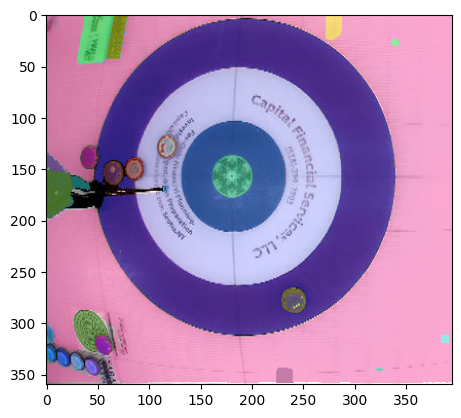

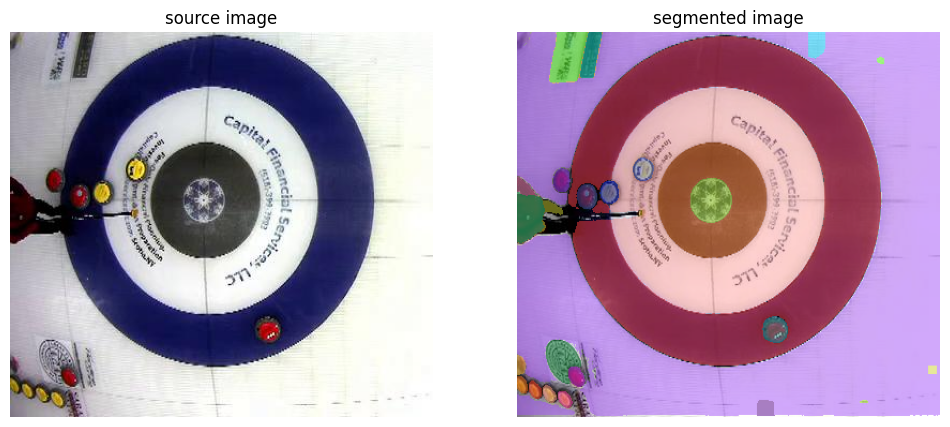

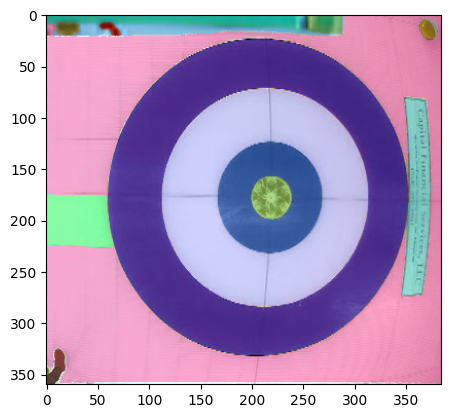

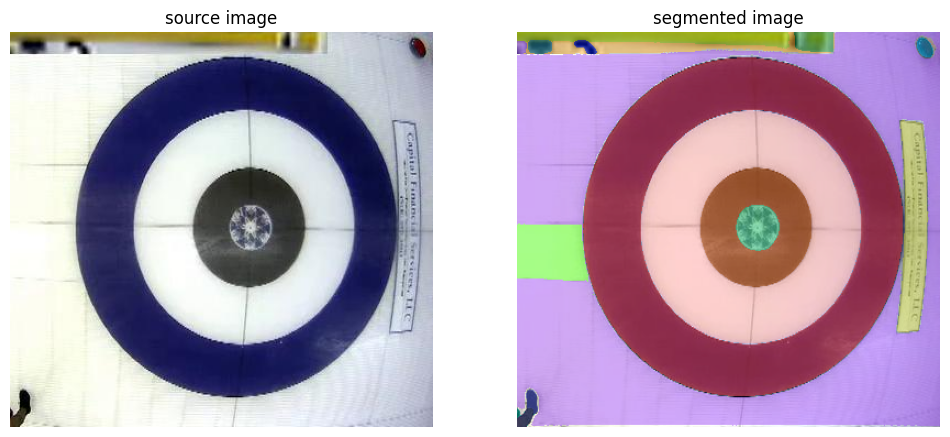

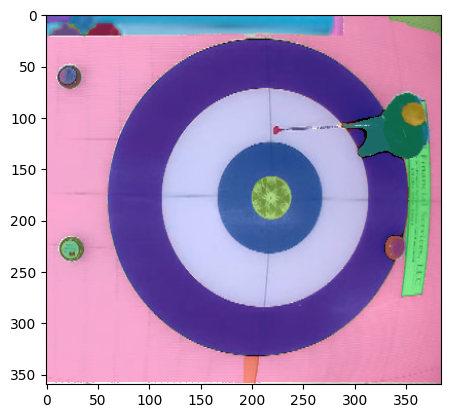

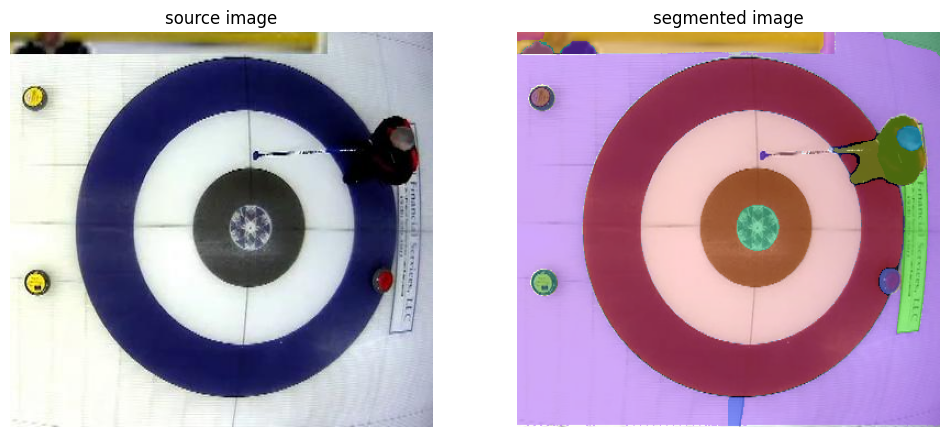

In [ ]:
counter = 0
for image, label in train_data:

  image = np.array(image)[:, :, ::-1]
  counter += 1
  if counter == 10:
    break

  sam_result = mask_generator.generate(image)
  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections.from_sam(sam_result=sam_result)

  annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

  plt.imshow(annotated_image)


  sv.plot_images_grid(
      images=[image, annotated_image],
      grid_size=(1, 2),
      titles=['source image', 'segmented image']
  )

  plt.show()